In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [187]:
dataframe = pd.read_csv("./heart.csv")
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [188]:
dataframe["target"] = dataframe["target"].replace(0, -1)
dataframe.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
478,39,1,2,140,321,0,0,182,0,0.0,2,0,2,1
702,71,0,1,160,302,0,1,162,0,0.4,2,2,2,1
91,62,0,0,124,209,0,1,163,0,0.0,2,0,2,1
248,39,0,2,138,220,0,1,152,0,0.0,1,0,2,1
655,41,1,1,110,235,0,1,153,0,0.0,2,0,2,1


In [189]:
def scalerTranfrom(features):
    new_features = features
    l2_norm = np.linalg.norm(new_features, 2, axis=1, keepdims=True)
    l2_normlized_feature = new_features / l2_norm
    
    return l2_normlized_feature

In [190]:
features = np.array(dataframe.drop(columns="target"))
labels = np.array(dataframe["target"])

# print(features.shape)
# features = scalerTranfrom(features)

features_train, features_test, labels_train, labels_test = train_test_split(features, labels)

In [191]:
# Support Vector Machine classifiers by kernel which is linear.
class SVM:
    def __init__(self, c=1, learning_rate=1):
        self.cost = c
        self.learning_rate = learning_rate
    
    def fit(self, features_train, labels_train):
        
        #store info
        self.d = features_train.shape[1]
        self.n_record = features_train.shape[0]
        
        # set up features and labels
        full_one = np.ones((self.n_record, 1))
        self.features = np.append(features_train, full_one, axis=1)
        self.labels = labels_train

        # set vector of weight by d dimensions
        self.weight = np.zeros(self.d + 1)
        self.array_weight = np.empty((0, self.d+1), float)
        
        for i in range(1000):
            self.weight = self.computeWeight(self.weight, self.features, self.labels, self.n_record) # compute to get weight's value
            
            self.array_weight = np.append(self.array_weight, [self.weight], axis=0)

        
    def computeWeight(self, weight, feature_train, labels_train, n_record):
        new_weight = weight
        for i in range(n_record):
            check = labels_train[i] * (np.inner(new_weight, feature_train[i]))
            if check < 1:
                new_weight = new_weight - self.learning_rate * (new_weight - np.inner(labels_train[i], feature_train[i]))
            else:
                new_weight = new_weight - self.learning_rate * new_weight
            
        return new_weight
    
    def predict(self, feature_test):
        new_feature_test = np.append(feature_test, 1)
        check = np.inner(self.weight, new_feature_test)
        if check >= 0 :
            # positive class
            return 1 
        else:
            # negative class
            return -1
    
    def hinge_loss(self, weight, features, labels, size):
        sum_loss = 0
        for i in range(size):
            check = 1-labels[i] * (np.inner(weight, features[i]))
            if check > 0:
                sum_loss += check
        return sum_loss
    
    def score(self, features_test, labels_test):
        size = features_test.shape[0]
        point = 0
        for i in range(size):
            y_predict = self.predict(features_test[i])
            if y_predict == labels_test[i]:
                point += 1
        
        return np.round(point / size, 4)
    
    def get_array_loss(self, features, labels):
        array_loss = np.array([])
        full_one = np.ones((features.shape[0], 1))
        new_features = np.append(features, full_one, axis=1)
        number_weight = self.array_weight.shape[0]
        number_record = features.shape[0]
        
        for i in range(number_weight):
            loss = self.hinge_loss(self.array_weight[i], new_features, labels, number_record)
            array_loss = np.append(array_loss, loss)
        
        return array_loss
            

In [192]:
model = SVM(learning_rate=0.000001)
model.fit(features_train, labels_train)
print(model.weight)

[-0.01170429 -0.06166304  0.14291566 -0.01935286 -0.00141243 -0.00235779
  0.01578432  0.0285304  -0.06763632 -0.13589921  0.04360233 -0.11172032
 -0.07619679 -0.00355312]


test accuracy

In [193]:
model.score(features_test, labels_test)

0.7237

train accuracy

In [194]:
model.score(features_train, labels_train)

0.7448

In [195]:
model.array_weight.shape

(1000, 14)

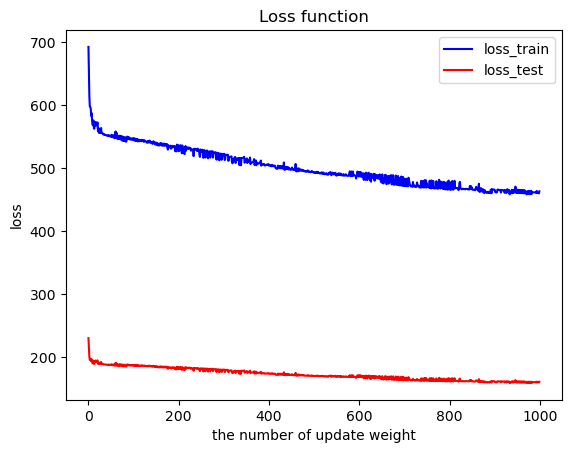

In [196]:
# plot that is loss training data
plt.plot(model.get_array_loss(features_train, labels_train), color="b", label = "loss_train")
# plot that is loss test data
plt.plot(model.get_array_loss(features_test, labels_test), color="r", label = "loss_test")
plt.ylabel("loss")
plt.xlabel("the number of update weight")
plt.title("Loss function")
plt.legend()
plt.show()

In [197]:
# Model Selection
class ModelSelection:
    def __init__(self, features, labels , model):
        self.features = features
        self.labels = labels
        self.model = model
    